# Deep Learning Introduction in NumPy

In [1]:
%matplotlib inline  
import numpy as np
from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegressionCV
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

## Data

In [2]:
X, y = make_moons(n_samples = 500, noise = 0.2, random_state = 101)

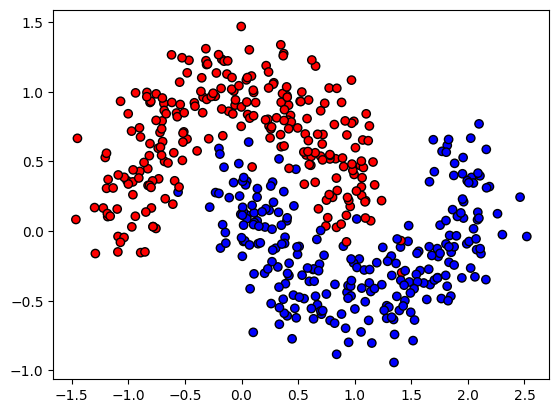

In [3]:
# visualisation
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], c = y, edgecolors='k', cmap = cm_bright)

## Logistic Regression

In our example, the output of the logistic regression is a value between 0 and 1 that tells the probability of a point being blue or red. The input of the model are the coordinates of the point.

$$f_{\theta}(x) = \frac{1}{1+\exp(-(\theta_0 + \theta_1 x_1 + \ldots + \theta_n x_n))}$$

In [4]:
clf = LogisticRegressionCV()
clf.fit(X,y)

LogisticRegressionCV()

We plot the result. We see how the model is actually finding a hyperplane defined by $\theta_0 + \theta_1 x_1 + \ldots + \theta_n x_n = 0$ that tries to separate the data

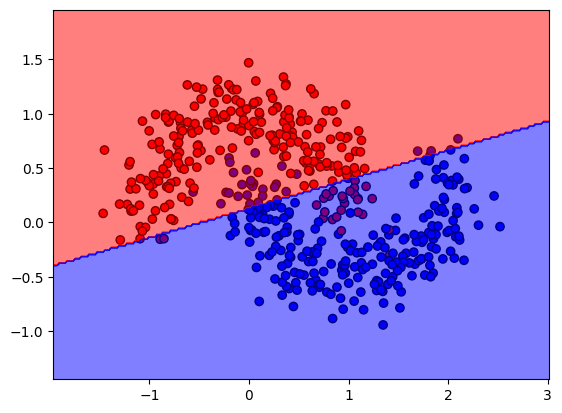

In [5]:
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], c = y, edgecolors='k', cmap = cm_bright)
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = 0.02 # step in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z_binary = Z>=0
Z_binary = Z_binary.reshape(xx.shape)
ax.contourf(xx, yy, Z_binary, cmap=cm_bright, alpha=.5)

## Neural Networks

### Ingredients

- Definition of the model to do a forward pass: $y = \sigma(W^{[L-1]}(\sigma(W^{[L-2]}(... \sigma(W^{[1]}x + b^{[1]})...)+b^{[L-2]}))+b^{[L-1]})$ where 
    - $\sigma$ is the activation function
    - $Wx + b$ is a linear function that goes from $\mathbb{R}^n$ to $\mathbb{R}^m$.
    - In our example, the output of the model is a value between 0 and 1 that tells the probability of a point being blue or red. The input of the model are the coordinates of the point. 
- Definition of a cost function that tells how good is the model in terms of its parameters: $$J(\theta), \text{where } \theta:=\{W^{[1]}, b^{[1]}, \ldots, W^{[L-1]}, b^{[L-1]}\}$$
- Optimisation of the cost function using gradient descent.
    - We need to apply the chain rule (backpropagation) in order to obtain $\partial_{\theta}J$ for each optimisation step.
   

#### Activation function and model definition

In [6]:
# activation function
def sigmoid(z):
    output = 1/(1+np.exp(-z))
    return output

In [7]:
# forward_model.
# function that takes the input x, and outputs the output of the model, as well as the intermediate layers
# I am defining a neural network with one hidden layer.
def forward_model(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # forward pass
    # hidden layer
    z2 = np.matmul(x,W1) + b1
    a2 = sigmoid(z2)
    
    # output layer
    z3 = np.matmul(a2,W2) + b2
    a3 = sigmoid(z3)
    
    return z2, a2, z3, a3

#### Loss function
Let $\mathcal{D} = \{(x^1, y^1), (x^2, y^2), \ldots, (x^N, y^N)\}$ be our training set, where $x^i\in \mathbb{R}^n$
We define the loss function as $$J(\theta) = \sum_{i=1}^{N} y^i \log(f_{\theta}(x^i)) + (1-y^i) \log(1-f_{\theta}(x^i))$$

In [8]:
def loss_fn(model, x, y):
    _,_,_,y_pred = forward_model(model, x)
    loss_batch = y * np.log(y_pred) + (1-y) * np.log(1-y_pred)
    return -np.sum(loss_batch)

#### Gradient descent step.
See for example (https://arxiv.org/pdf/1801.05894.pdf) for a general form of the gradient of the cost function for the parameters in each layer of the network.



In [9]:
def GD_step(model, x, y, lr = 0.001):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    z2, a2, z3, a3 = forward_model(model, x)
    
    delta3 = a3-y
    dW2 = np.matmul(a2.T,delta3)
    db2 = np.sum(delta3, axis=0, keepdims=True)
    
    delta2 = sigmoid(z2)*(1-sigmoid(z2)) * delta3.dot(W2.T)
    dW1 = np.matmul(x.T, delta2)
    db1 = np.sum(delta2, axis=0)
    
    W2 = W2 - lr * dW2
    b2 = b2 - lr * db2
    W1 = W1 - lr * dW1
    b1 = b1 - lr * db1
    
    model['W1'], model['b1'], model['W2'], model['b2'] = W1, b1, W2, b2
    return model

#### We put everything together for the training:
- Initialise $W^{[1]}, b^{[1]}, \ldots, W^{[L-1]}, b^{[L-1]}$.
- While Not convergence:
    - Calculate $J(\theta)$
    - Update $W^{[i]} := W^{[i]} - \alpha \cdot \partial_{W^{[i]}}J$
    - Update $b^{[i]} := b^{[i]} - \alpha \cdot \partial_{b^{[i]}}J$
    

In [10]:
def train(model, n_epochs, X, y):
    for epoch in range(n_epochs):
        model = GD_step(model, x=X, y=y)
        loss = loss_fn(model, x=X, y=y)
        if epoch%10 == 0:
            print("Epoch: {}/{}, loss: {}".format(epoch, n_epochs, loss))
    return model

In [11]:
%%time
n_hidden = 30
W1 = np.random.randn(2, n_hidden)
b1 = np.random.randn(1, n_hidden)
W2 = np.random.randn(n_hidden, 1)
b2 = np.random.randn(1,1)
model = {}
model['W1'], model['b1'], model['W2'], model['b2'] = W1, b1, W2, b2

model = train(model=model, n_epochs=10000, X=X, y=y.reshape(500,1))

Epoch: 0/10000, loss: 232.48038622745065
Epoch: 10/10000, loss: 187.4504934122395
Epoch: 20/10000, loss: 169.90345527617788
Epoch: 30/10000, loss: 159.8911853207661
Epoch: 40/10000, loss: 153.21198463647255
Epoch: 50/10000, loss: 148.40182700022262
Epoch: 60/10000, loss: 144.77694457158051
Epoch: 70/10000, loss: 141.95340791595453
Epoch: 80/10000, loss: 139.69068887605482
Epoch: 90/10000, loss: 137.82841135897132
Epoch: 100/10000, loss: 136.2556901688817
Epoch: 110/10000, loss: 134.89405296031373
Epoch: 120/10000, loss: 133.68701184148722
Epoch: 130/10000, loss: 132.5933327381045
Epoch: 140/10000, loss: 131.58254459950993
Epoch: 150/10000, loss: 130.6318782964534
Epoch: 160/10000, loss: 129.72414814482278
Epoch: 170/10000, loss: 128.846268519348
Epoch: 180/10000, loss: 127.9882050408868
Epoch: 190/10000, loss: 127.14222649489956
Epoch: 200/10000, loss: 126.30236648961954
Epoch: 210/10000, loss: 125.4640321194801
Epoch: 220/10000, loss: 124.62371596237783
Epoch: 230/10000, loss: 123.778

#### Prediction

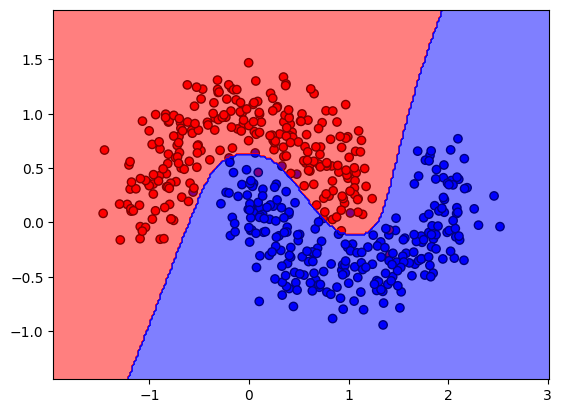

In [12]:
_,_,_,y_pred = forward_model(model, X)
y_pred = y_pred.ravel()

fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], c = y.ravel(), edgecolors='k', cmap = cm_bright)
_,_,_,Z = forward_model(model=model, x=np.c_[xx.ravel(), yy.ravel()])
Z_binary = Z>=0.5
Z_binary = Z_binary.reshape(xx.shape)
ax.contourf(xx, yy, Z_binary, cmap=cm_bright, alpha=.5)